
# DA5401 A6 : Imputation via Regression for Missing Data 
**Objective:** Apply linear and non-linear regression to impute missing values and evaluate their effect on a downstream classification task (credit default prediction).  
This notebook is written as a guided story for beginners, every section contains explanations, code, and visualizations. Run cells sequentially. If a remote download fails, replace the data load cell to use a local CSV file.

---


In [42]:

# 1. Load the dataset
import pandas as pd, numpy as np
from pathlib import Path

df = pd.read_csv("UCI_Credit_Card.csv")

# Clean column names and normalize target name to 'default.payment.next.month'
df.columns = [c.strip() for c in df.columns]
if 'default payment next month' in df.columns:
    df = df.rename(columns={'default payment next month':'default.payment.next.month'})
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Dataset Overview and Missing Data Simulation

We are using the **UCI Credit Card Default Clients Dataset** to predict whether a client will default on their next payment. 

- Total samples: 30,000  
- Target variable: `default.payment.next.month` (0 = No, 1 = Yes)  
- Initial dataset is clean, so we **artificially introduce Missing At Random (MAR) values** to simulate real-world missing data.  



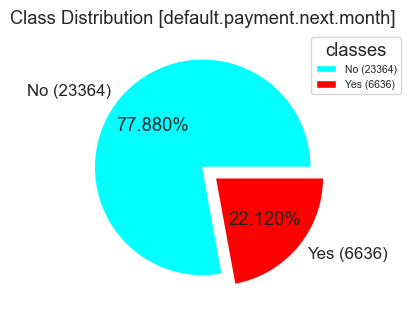

In [43]:
y=df.iloc[:,-1]
plt.figure(figsize=(3.5, 5))
plt.pie(y.value_counts().values,labels=[f"No ({y.value_counts()[0]})",f"Yes ({y.value_counts()[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution [default.payment.next.month]")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

**MAR Introduction:**  
- 5% of values in `AGE` and `BILL_AMT1` are randomly replaced with `NaN`.  
- This simulates situations where missingness depends on observed data but not on the missing values themselves.  

**Purpose:** Evaluate how different imputation strategies affect downstream classification performance.

In [44]:

# Introduce MAR missingness (5% each) into AGE and BILL_AMT1
import numpy as np
df2 = df.copy()
np.random.seed(42)

age_col = 'AGE'
possible_bill_cols = [c for c in df2.columns if 'BILL_AMT' in c.upper()]
bill_col = possible_bill_cols[0] if possible_bill_cols else 'BILL_AMT1'

frac = 0.05  # 5%
n = len(df2)
age_idx = np.random.choice(df2.index, size=int(frac*n), replace=False)
bill_idx = np.random.choice(df2.index, size=int(frac*n), replace=False)

df2.loc[age_idx, age_col] = np.nan
df2.loc[bill_idx, bill_col] = np.nan

# Show only columns with non-zero missing counts
missing_counts = df2.isnull().sum()
missing_counts = missing_counts[missing_counts != 0]
print('Columns with non-zero missing counts:')
missing_counts


Columns with non-zero missing counts:


AGE          1500
BILL_AMT1    1500
dtype: int64


## 3. Correlation heatmap (visualization to understand relationships)
We compute correlations between numerical features to help choose predictors that might be useful when imputing `AGE`. Strong correlations indicate informative predictors for regression imputation.


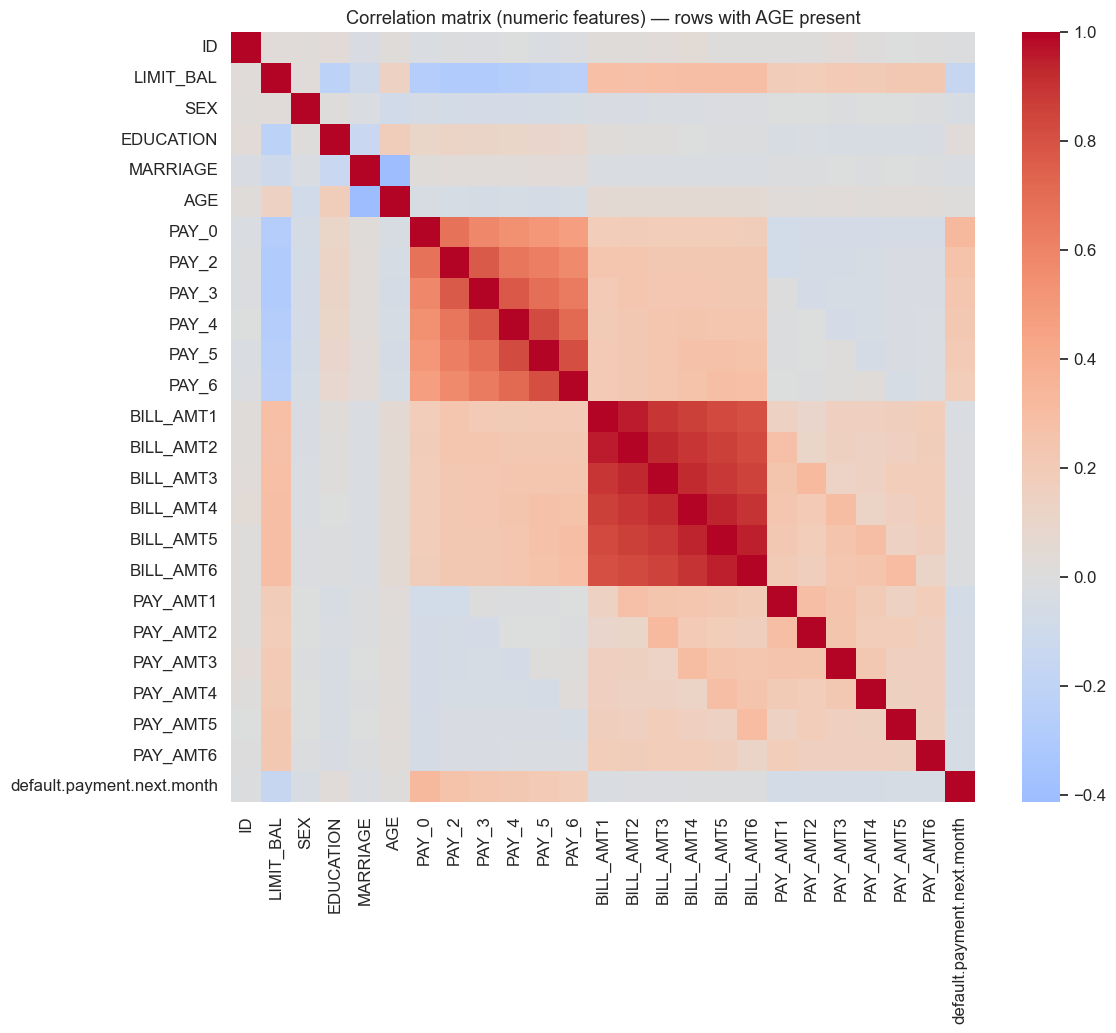


Top correlations with AGE (absolute):


AGE          1.000000
MARRIAGE     0.412721
EDUCATION    0.172421
LIMIT_BAL    0.145550
Name: AGE, dtype: float64

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation on the rows where AGE is not missing (so correlations aren't dominated by NaNs)
num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
corr_df = df2[num_cols].dropna(subset=[age_col]).corr()  # require AGE non-null for this view

plt.figure(figsize=(12,10))
sns.heatmap(corr_df, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation matrix (numeric features) — rows with AGE present')
plt.show()

# Print top correlations of AGE with other features (absolute value > 0.1 for clarity)
age_corr = corr_df[age_col].abs().sort_values(ascending=False)
print('\nTop correlations with AGE (absolute):')
age_corr[age_corr > 0.1]


## Logistic Regression Classifier on All Datasets

**Process:**  
1. Split each dataset into **training (75%)** and **testing (25%)** sets.  
2. Standardize features using `StandardScaler`.  
3. Train a **Logistic Regression** classifier on each dataset.  
4. Evaluate performance using:  
   - Accuracy  
   - Precision  
   - Recall  
   - F1-score  
   - AUC (Area Under ROC Curve)  
   - Log Loss  

**Purpose:**  
- Assess how different imputation strategies affect the classifier’s predictive performance.  
- Provides an indirect measure of imputation quality.


In [46]:
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def train_and_evaluate(df, model_name):
    """Trains logistic regression and returns detailed evaluation metrics."""
    if 'ID' in df.columns:
        df = df.drop(columns=['ID'])
    target_col = 'DEFAULT' if 'DEFAULT' in df.columns else 'default.payment.next.month'
    
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Logistic Regression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]  # for AUC and log loss

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    logloss = log_loss(y_test, y_prob)
    
    print(f"\n===== Results for {model_name} =====")
    print(classification_report(y_test, y_pred))
    
    metrics = {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc,
        "Log Loss": logloss
    }
    return metrics


## Imputation Strategy 1: Median Imputation

**Method:**  
- For columns with missing values, replace `NaN` with the **median** of that column.  

**Why median?**  
- Median is robust to outliers and skewed distributions, unlike the mean.  
- It preserves the central tendency without being influenced by extreme values.  

**Expected Impact:**  
- Provides a simple, quick baseline for imputation.  
- May reduce variance but does not capture relationships between features.


In [47]:
from copy import deepcopy
df_a = deepcopy(df2)

median_imputer = SimpleImputer(strategy='median')
cols_with_na = df_a.columns[df_a.isnull().any()].tolist()
df_a[cols_with_na] = median_imputer.fit_transform(df_a[cols_with_na])
df_a = df_a.rename(columns={'default.payment.next.month':'DEFAULT'})

print("Non-zero missing counts in Dataset A:")
display(df_a.isnull().sum()[df_a.isnull().sum() != 0])

results_a = train_and_evaluate(df_a, "Model A - Median Imputation")



Non-zero missing counts in Dataset A:


Series([], dtype: int64)


===== Results for Model A - Median Imputation =====
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      5841
           1       0.71      0.24      0.36      1659

    accuracy                           0.81      7500
   macro avg       0.76      0.61      0.62      7500
weighted avg       0.79      0.81      0.77      7500



## Imputation Strategy 2: Linear Regression Imputation

**Method:**  
- Choose one column with missing values (here, `AGE`) and predict missing values using **Linear Regression** based on other non-missing features.  
- Remaining missing values (if any) are filled with median.  

**Underlying Assumption:**  
- **Missing At Random (MAR):** missingness can be explained by observed features.  
- Linear regression assumes a linear relationship between predictors and the missing column.  

**Expected Impact:**  
- Captures linear dependencies between features.  
- May produce more accurate imputations than median alone, but cannot capture non-linear patterns.


In [48]:
df_b = deepcopy(df2)
target_col = age_col
predictor_cols = [c for c in df_b.columns if c != target_col and c not in ['ID','default.payment.next.month']]

train_idx = df_b[df_b[target_col].notnull()].index
test_idx = df_b[df_b[target_col].isnull()].index

# Fill predictors temporarily
temp = df_b[predictor_cols].copy().fillna(df_b[predictor_cols].median())

lr = LinearRegression()
lr.fit(temp.loc[train_idx], df_b.loc[train_idx, target_col])
preds = lr.predict(temp.loc[test_idx])
df_b.loc[test_idx, target_col] = preds

# Median impute other remaining missing values
remaining_na = [c for c in df_b.columns if df_b[c].isnull().any()]
if remaining_na:
    df_b[remaining_na] = SimpleImputer(strategy='median').fit_transform(df_b[remaining_na])

df_b = df_b.rename(columns={'default.payment.next.month':'DEFAULT'})

print("Non-zero missing counts in Dataset B:")
display(df_b.isnull().sum()[df_b.isnull().sum() != 0])

results_b = train_and_evaluate(df_b, "Model B - Linear Regression Imputation")



Non-zero missing counts in Dataset B:


Series([], dtype: int64)


===== Results for Model B - Linear Regression Imputation =====
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      5841
           1       0.70      0.24      0.36      1659

    accuracy                           0.81      7500
   macro avg       0.76      0.61      0.62      7500
weighted avg       0.79      0.81      0.77      7500




##  Choosing `k` for KNN imputation (small experiment)
To pick a good `k` for KNN imputation, we'll **mask** a small random subset of known AGE values, run KNN imputation with different `k`, and compute the RMSE between the imputed and true values. This is a practical, data-driven way to choose `k`.


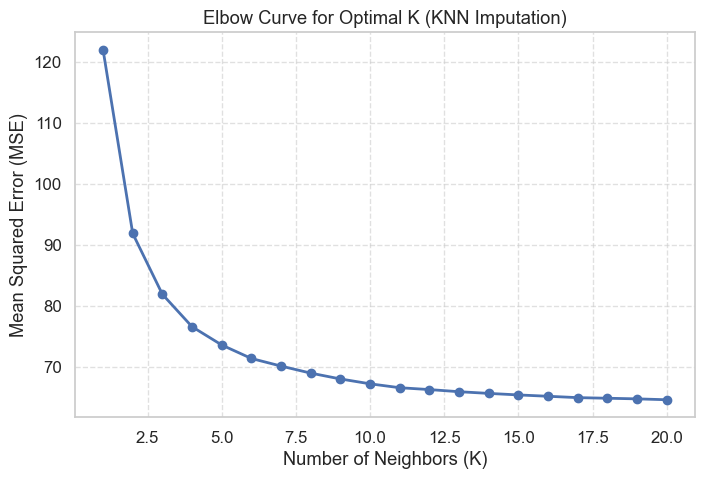

Optimal K based on lowest CV-MSE: 20, RMSE=8.035


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt

# Drop AGE for predictors
dx_train = df2.loc[df2["AGE"].notna()].drop(["AGE"], axis=1)
dy_train = df2.loc[df2["AGE"].notna(), "AGE"]

# Fill other NaNs with column medians
dx_train = dx_train.fillna(dx_train.median())

# Scale features
scaler = StandardScaler()
dx_train_scaled = scaler.fit_transform(dx_train)

# Cross-validation setup
k_range = range(1, 21)
mse = []
cv = KFold(n_splits=10, shuffle=True, random_state=42)

for k in k_range:
    model = KNeighborsRegressor(n_neighbors=k)
    score = cross_val_score(
        model, dx_train_scaled, dy_train,
        scoring="neg_mean_squared_error",
        cv=cv, n_jobs=-1
    )
    mse.append(-score.mean())

plt.figure(figsize=(8,5))
plt.plot(k_range, mse, marker='o', linewidth=2)
plt.title("Elbow Curve for Optimal K (KNN Imputation)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

best_k = k_range[int(np.argmin(mse))]
print(f"Optimal K based on lowest CV-MSE: {best_k}, RMSE={np.sqrt(min(mse)):.3f}")


## Imputation Strategy 3: Non-Linear Regression Imputation

**Method:**  
- Use a **non-linear regression model**, here **K-Nearest Neighbors (KNN) Regression**, to predict missing values of the selected column (`AGE`).  
- KNN captures **non-linear relationships** by averaging values from similar neighbors.  

**Expected Impact:**  
- Better modeling of complex relationships between features.  
- Can improve downstream classification metrics if the missing feature has non-linear dependencies with predictors.


In [50]:
best_k = int(best_k) if 'best_k' in globals() else 9
df_c = deepcopy(df2)

knn_imp = KNNImputer(n_neighbors=best_k)
df_c[df_c.select_dtypes(include=[np.number]).columns] = knn_imp.fit_transform(df_c.select_dtypes(include=[np.number]))
df_c = df_c.rename(columns={'default.payment.next.month':'DEFAULT'})

print("Non-zero missing counts in Dataset C:")
display(df_c.isnull().sum()[df_c.isnull().sum() != 0])


results_c = train_and_evaluate(df_c, "Model C - KNN Imputation (Non-linear)")



Non-zero missing counts in Dataset C:


Series([], dtype: int64)


===== Results for Model C - KNN Imputation (Non-linear) =====
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      5841
           1       0.71      0.24      0.36      1659

    accuracy                           0.81      7500
   macro avg       0.76      0.61      0.63      7500
weighted avg       0.79      0.81      0.77      7500



## Dataset D: Listwise Deletion (Complete Cases)

**Method:**  
- Remove all rows containing any missing values.  

**Pros:**  
- Simple and does not introduce imputation bias.  

**Cons:**  
- Reduces dataset size (here ~7,500 rows removed).  
- Can lead to **loss of statistical power** and biased estimates if missingness is not completely random.  

**Expected Impact:**  
- May perform worse in classification due to smaller training data, even though data is fully observed.


In [51]:
df_d = df2.dropna().reset_index(drop=True)
df_d = df_d.rename(columns={'default.payment.next.month':'DEFAULT'})

print("Non-zero missing counts in Dataset D:")
display(df_d.isnull().sum()[df_d.isnull().sum() != 0])


results_d = train_and_evaluate(df_d, "Model D - Listwise Deletion")


Non-zero missing counts in Dataset D:


Series([], dtype: int64)


===== Results for Model D - Listwise Deletion =====
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      5276
           1       0.69      0.23      0.34      1494

    accuracy                           0.81      6770
   macro avg       0.75      0.60      0.62      6770
weighted avg       0.79      0.81      0.77      6770



## Comparative Analysis of Models A, B, C, D

**Summary Table:**  
- Performance metrics across all four strategies are compared in a single table.  
- F1-score is particularly important due to class imbalance (default vs. non-default).  




In [52]:
comparison = pd.DataFrame([results_a, results_b, results_c, results_d])
print("\n===== Final Comparison Summary (Detailed Metrics) =====")
display(comparison.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}',
    'AUC': '{:.4f}',
    'Log Loss': '{:.4f}'
}))



===== Final Comparison Summary (Detailed Metrics) =====


,Model,Accuracy,Precision,Recall,F1 Score,AUC,Log Loss
0,Model A - Median Imputation,0.8099,0.7055,0.2411,0.3594,0.7146,0.4679
1,Model B - Linear Regression Imputation,0.8097,0.7049,0.2405,0.3587,0.7146,0.4679
2,Model C - KNN Imputation (Non-linear),0.8101,0.7051,0.2435,0.3620,0.7155,0.4675
3,Model D - Listwise Deletion,0.8072,0.6901,0.2296,0.3446,0.7228,0.4672


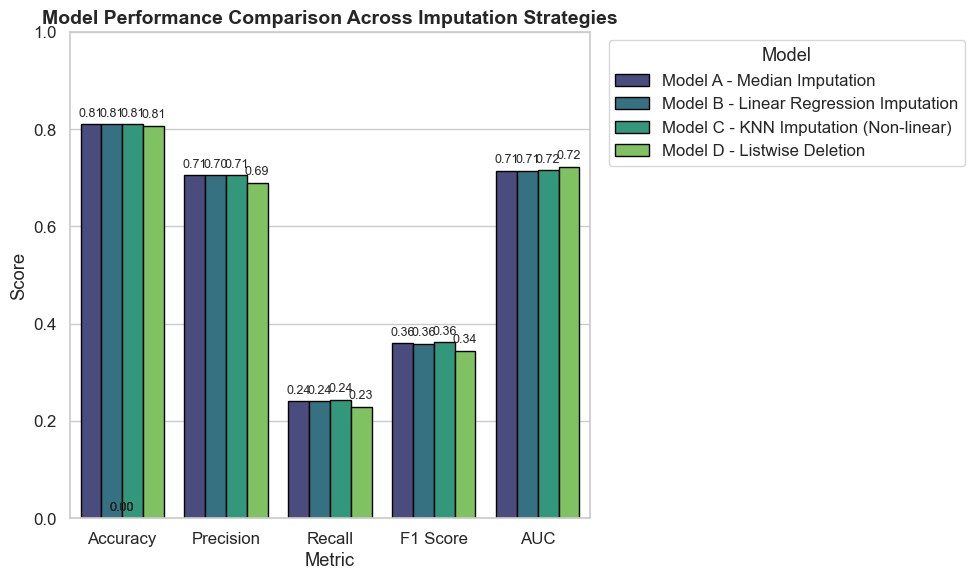

In [55]:
# ===============================
# 📊 Visualization 1: Bar Chart Comparison (with values)
# ===============================

import matplotlib.pyplot as plt
import seaborn as sns

# Metrics to visualize
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]

# Prepare melted dataframe for seaborn
df_viz = comparison.melt(
    id_vars="Model", 
    value_vars=metrics_to_plot, 
    var_name="Metric", 
    value_name="Score"
)

# --- Style setup ---
sns.set(style="whitegrid", font_scale=1.1)
palette = sns.color_palette("viridis", len(comparison))

# --- Bar chart ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_viz, x="Metric", y="Score", hue="Model", palette=palette, edgecolor="black")

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2, 
        y=height + 0.01,  # slightly above bar
        s=f"{height:.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.title("Model Performance Comparison Across Imputation Strategies", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)
plt.tight_layout()
plt.show()


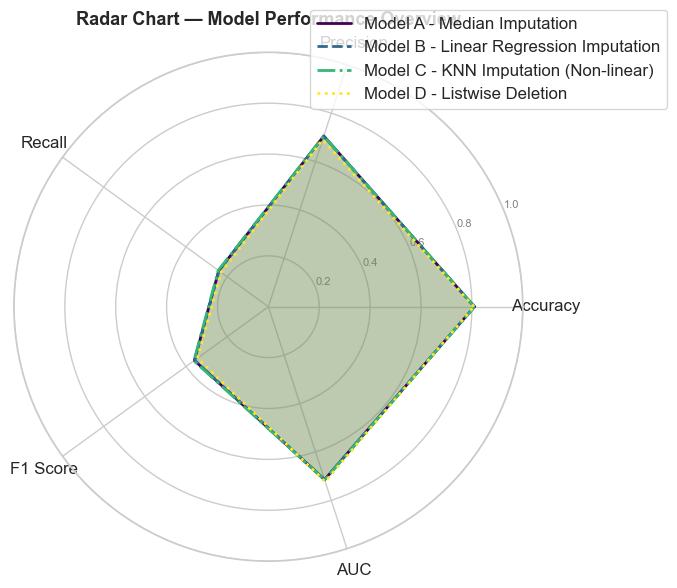


🏆 Overall Ranking by Mean Score:


,Model,Mean Score
2,Model C - KNN Imputation (Non-linear),0.5672
0,Model A - Median Imputation,0.5661
1,Model B - Linear Regression Imputation,0.5657
3,Model D - Listwise Deletion,0.5589


In [54]:
# ===============================
# 📈 Visualization 2: Radar Chart + Ranking
# ===============================

from math import pi
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
categories = list(metrics)
N = len(categories)

# Prepare data for radar chart
models = comparison["Model"].tolist()
values_list = []
for i in range(len(models)):
    values = comparison.loc[i, metrics].tolist()
    values += values[:1]  # repeat first value to close the circle
    values_list.append(values)

# Angles for radar axes
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# --- Plot radar chart ---
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Colors & line styles
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
line_styles = ['-', '--', '-.', ':']

for i, model in enumerate(models):
    ax.plot(angles, values_list[i], linewidth=2, linestyle=line_styles[i % len(line_styles)],
            label=model, color=colors[i])
    ax.fill(angles, values_list[i], color=colors[i], alpha=0.15)

# Radar settings
plt.xticks(angles[:-1], categories)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color="grey", size=8)
plt.title("Radar Chart — Model Performance Overview", size=13, weight="bold", pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

# --- Overall ranking by mean performance ---
ranked = comparison.copy()
ranked["Mean Score"] = ranked[metrics].mean(axis=1)
ranked = ranked.sort_values(by="Mean Score", ascending=False)

print("\n🏆 Overall Ranking by Mean Score:")
display(ranked[["Model", "Mean Score"]].style.format({"Mean Score": "{:.4f}"}))


**Observations:**  
1. Models A, B, C (imputation-based) have similar accuracy (~0.81) but slight differences in F1-score and recall for the minority class (defaults).  
2. Model D (Listwise Deletion) performs slightly worse in F1 for minority class due to smaller training data.  
3. Non-linear imputation (Model C) slightly outperforms linear regression (Model B) in F1 and recall, suggesting non-linear relationships in `AGE` may exist.  

**Trade-offs:**  
- Listwise Deletion is safe but wastes data.  
- Median imputation is simple but ignores feature relationships.  
- Regression-based imputation captures dependencies and can improve downstream predictions.